In [10]:
import csv
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import numpy as np
import math

In [11]:
relabel_split_path = "/dhc/groups/ocdetect/relabel_split"
labels = ["Certain", "Begin uncertain","End uncertain", "Begin AND End uncertain", "No label"]
relabeled_subjects_path = "/dhc/groups/ocdetect/relabeled_subjects"
label_windows_clean_path = "/dhc/groups/ocdetect/label_windows_clean"
clean_labels_path = '/dhc/groups/ocdetect/thesis/cleaned_labels'
automated_labels_path = "/dhc/groups/ocdetect/thesis/automated_labels"
labels_windows = '/dhc/groups/ocdetect/thesis/label_windows'
extracted_labels = '/dhc/groups/ocdetect/thesis/extracted_labels'
subjects = ["01", "03", "04", "18", "20", "30"]
annotators = ["a1", "a2", "a3", "a4"]
colors = ['#F6A800', '#8B9094', '#B1063A', '#5A6065', '#DD6108', "#ABAFB2"]

In [20]:
#Count total number of user-set labels for given subjects
# output in a csv file total_labels_df
# used as 100% of labels when compared with annotator-set labels

def count_total_number_of_user_set_labels():
    total_labels = "number_of_user_set_labels_per_subject.csv"
    
    if not os.path.exists(total_labels):
        subject_data_frames = {}
        subject_row_count = {}

        for subject in subjects:
            subject_data = []
            num_of_labels = 0 
            # Iterate over each directory
            for entry in os.scandir(relabel_split_path):
                if entry.is_dir() and entry.name.startswith('OCDetect_'):
                    folder_name = entry.name
                    key = folder_name.replace('OCDetect_', '')
                    if key.startswith(subject):
                        target_dir = os.path.normpath(os.path.join(relabel_split_path, folder_name))
                        for file_entry in os.scandir(target_dir):
                            if file_entry.is_file() and file_entry.name.endswith('.csv'):
                                df = pd.read_csv(os.path.normpath(os.path.join(target_dir, file_entry.name)))
                                # Filter the data frame for 'user yes/no' column equals 1
                                filtered_df = df[df['user yes/no'] == 1.0]
                                if not filtered_df.empty:
                                    num_of_labels += filtered_df.shape[0]
            subject_row_count[subject] = num_of_labels
    
        with open(total_labels, 'w', newline='') as csvfile:
            fieldnames = ['Subject', 'Number of Labels']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for subject, count in subject_row_count.items():
                writer.writerow({'Subject': subject, 'Number of Labels': count})
    return pd.read_csv(total_labels, dtype={'Subject': str})
total_labels_df = count_total_number_of_user_set_labels()
print(total_labels_df)


  Subject  Number of Labels
0      01               362
1      03               225
2      04               130
3      18               398
4      20               366
5      30               195


In [21]:
# Function to count the number of set labels
def count_labels_total(path):
    label_count = 0
    with open(path, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            labels_json = row.get("label", "[]")
            if labels_json:
                labels = json.loads(labels_json)
                for label in labels:
                    timeserieslabels = label.get("timeserieslabels", [])
                    label_count += len(timeserieslabels)
    return label_count

def in_percent(value, total):
    return round(value * 100 / total, 2)

In [22]:
# Number of set labels by annotator per subject and it's percentage
# haven't changed it to labels after cleaning
def calculate_number_of_set_labels_by_subject_and_annotator():
    set_labels_count_name = "number_of_labels_by_subject_and_annotator.csv"
    with open(set_labels_count_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Subject", "Annotator", "Number of Set Labels", "Percent of Set Labels"])
                
        for subject in subjects:
            for annotator in annotators:
                path = os.path.join(relabeled_subjects_path, f"{annotator}_subject_{subject}.csv")
                if os.path.exists(path):
                    labels = count_labels_total(path)
                    if labels:
                        matching = total_labels_df[total_labels_df['Subject'] == subject]
                        percent = in_percent(labels, matching['Number of Labels'].iloc[0])
                        writer.writerow([subject, annotator, labels, percent])
    
    return pd.read_csv(set_labels_count_name, dtype={'Subject': str})
set_labels_count_df = calculate_number_of_set_labels_by_subject_and_annotator()
print(set_labels_count_df)

   Subject Annotator  Number of Set Labels  Percent of Set Labels
0       01        a1                   235                  64.92
1       01        a4                   195                  53.87
2       03        a1                   208                  92.44
3       03        a2                   212                  94.22
4       04        a2                   115                  88.46
5       04        a3                   127                  97.69
6       18        a1                   308                  77.39
7       18        a3                   347                  87.19
8       20        a3                   343                  93.72
9       20        a4                   323                  88.25
10      30        a2                   169                  86.67
11      30        a4                   124                  63.59


In [23]:
#help functions
def labels_in_percent(labels_sum, total_labels):
    for key, value in labels_sum.items():
        labels_sum[key] = round(value * 100 / total_labels, 2)
    return labels_sum

def sum_of_dictionary(dicti):
    sum = 0
    for key, value in dicti.items():
        sum+=value
    return sum;
    
# Returns the number of user-set labels for the subject   
def get_total_user_labels(subject):
    return total_labels_df[total_labels_df['Subject'] == subject]['Number of Labels'].iloc[0]

# calculates the number of set labels by type
def count_labels_sum(file_pattern):
    label_sum = {
        "Certain": 0,
        "Begin uncertain": 0,   
        "End uncertain": 0,
        "Begin AND End uncertain": 0,
        "No Label": 0
    }
    path = os.path.join(relabeled_subjects_path, file_pattern)
    file_list = glob.glob(path)
    should_be_labels = 0
    # Iterate through each file
    for file_name in file_list:
        with open(file_name, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                labels_json = row.get("label")
                if labels_json:  # Check if the value is not empty
                    labels = json.loads(labels_json)
                    for label in labels:
                        timeserieslabels = label.get("timeserieslabels", [])
                        for l in timeserieslabels:
                            if l == "Certain":
                                label_sum["Certain"] += 1
                            elif l == "Begin AND End uncertain":
                                label_sum["Begin AND End uncertain"] += 1
                            elif l == "End uncertain":
                                label_sum["End uncertain"] += 1
                            elif l == "Begin uncertain":
                                label_sum["Begin uncertain"] += 1
        
            dot_index = file_name.find(".")
            subject = file_name[dot_index - 2:dot_index]
            should_be_labels += get_total_user_labels(subject)

    sum = sum_of_dictionary(label_sum)
    label_sum['No Label'] = should_be_labels - sum
    
    return label_sum

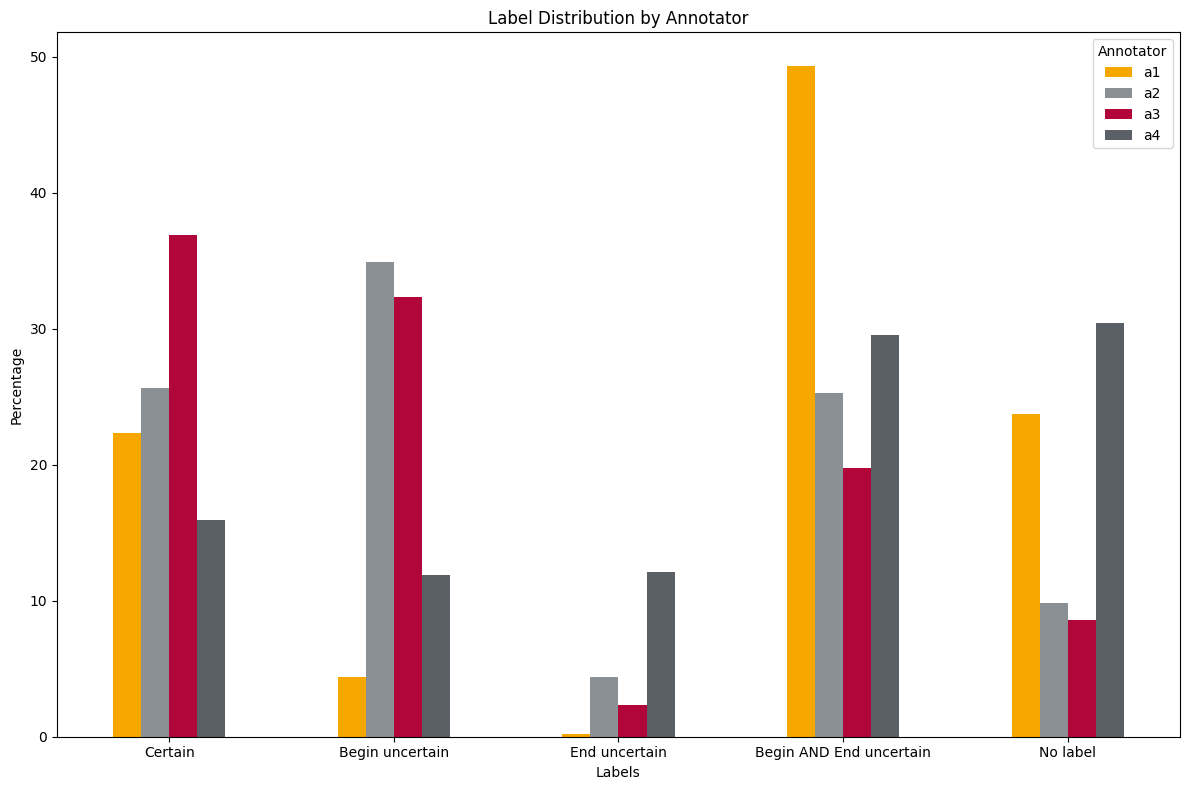

  Annotator  Certain  Begin uncertain  End uncertain  Begin AND End uncertain  \
0        a1    22.34             4.37           0.20                    49.34   
1        a2    25.64            34.91           4.36                    25.27   
2        a3    36.91            32.33           2.35                    19.80   
3        a4    15.93            11.92          12.13                    29.58   

   No label  
0     23.76  
1      9.82  
2      8.61  
3     30.44  


In [24]:
# Calculates distribution of label types in percent
def calculate_distributio_of_label_types_in_percent_by_annotator():    
    file_name = "label_type_distribution_in_percent.csv"
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Annotator'] + labels)
            
        for annotator in annotators:   
            labels_sum = count_labels_sum(annotator + "*")
            sum = 0
            total_set_labels = 0
            for subject in subjects:
                path = os.path.join(relabeled_subjects_path, f"{annotator}_subject_{subject}.csv")
                if os.path.exists(path):
                    sum += get_total_user_labels(subject)
    
            writer.writerow([annotator] + list(labels_in_percent(labels_sum, sum).values()))
    
    df = pd.read_csv(file_name)  
    df.set_index("Annotator", inplace=True)
    df = df.T
    fig, ax = plt.subplots(figsize=(12, 8))
    df.plot(kind='bar', ax=ax, color=colors)
    plt.title('Label Distribution by Annotator')
    plt.xlabel('Labels')
    plt.ylabel('Percentage')
    plt.xticks(rotation=0, ha='center')
    plt.legend(title='Annotator')
    
    plt.tight_layout()
    plt.show()
    return pd.read_csv(file_name, dtype={'Subject': str})
distribution_of_label_type_df = calculate_distributio_of_label_types_in_percent_by_annotator()
print(distribution_of_label_type_df)


   Subject Annotator  Certain  Begin uncertain  End uncertain  \
0       01        a1    25.69             9.12           0.28   
1       01        a4    21.55            18.78           3.87   
2       03        a1    37.33             2.67           0.44   
3       03        a2    35.56            32.89           3.11   
4       04        a2    22.31            26.92           8.46   
5       04        a3    53.08            20.00           2.31   
6       18        a1    10.80             1.01           0.00   
7       18        a3    43.47            19.85           2.51   
8       20        a3    24.04            50.27           2.19   
9       20        a4    18.31            10.11          26.50   
10      30        a2    16.41            42.56           3.08   
11      30        a4     1.03             2.56           0.51   

    Begin AND End uncertain  No label  Total number of labels  
0                     29.83     35.08                     362  
1                      9.6

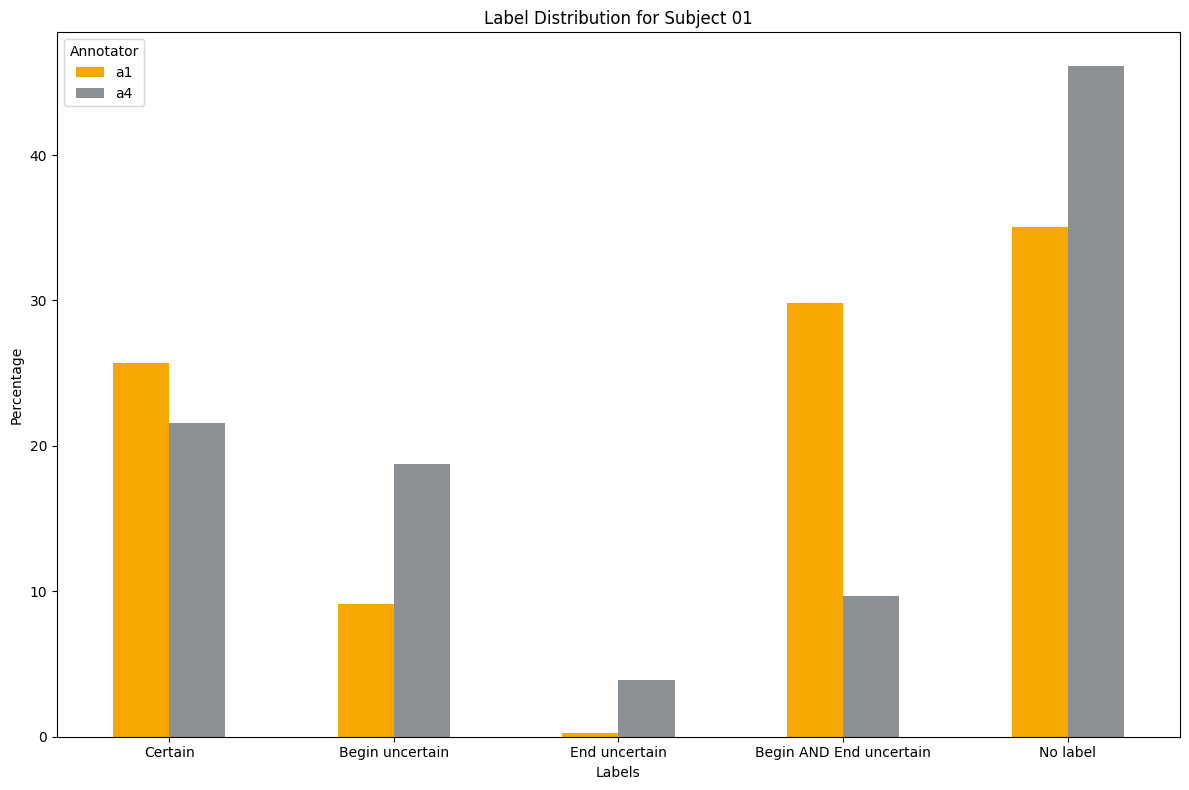

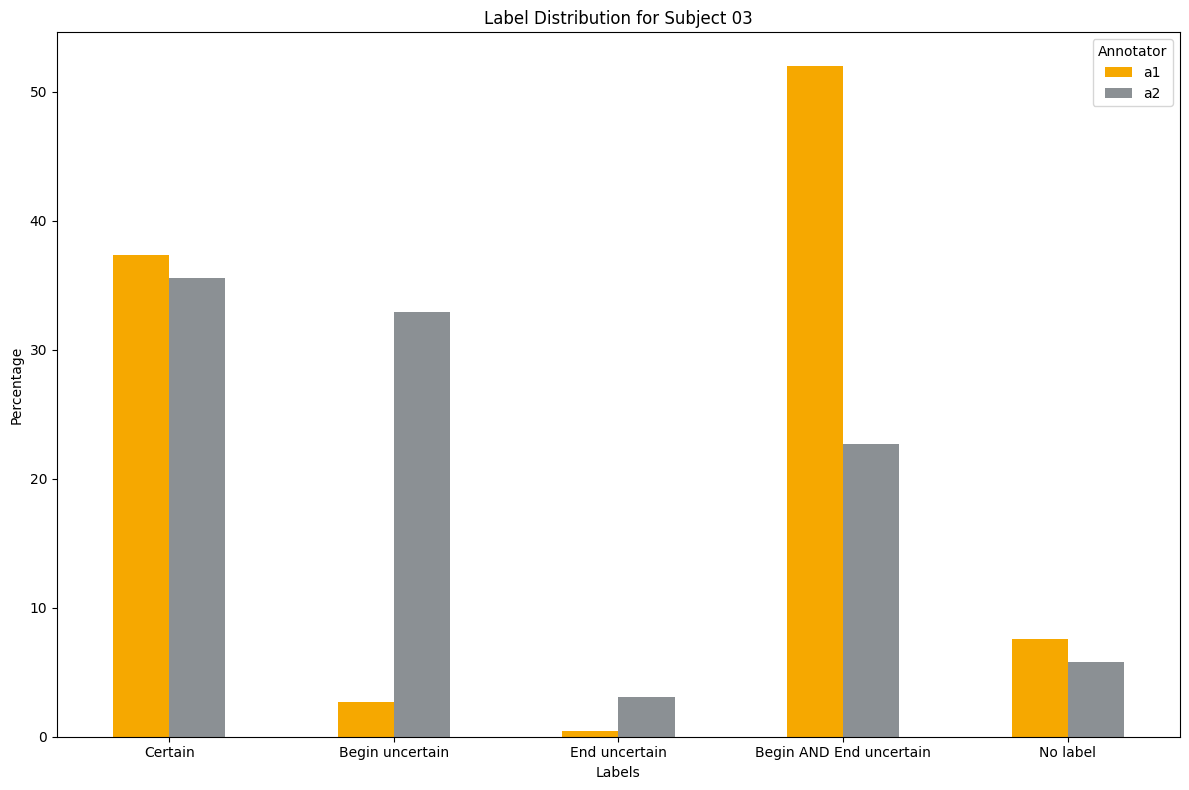

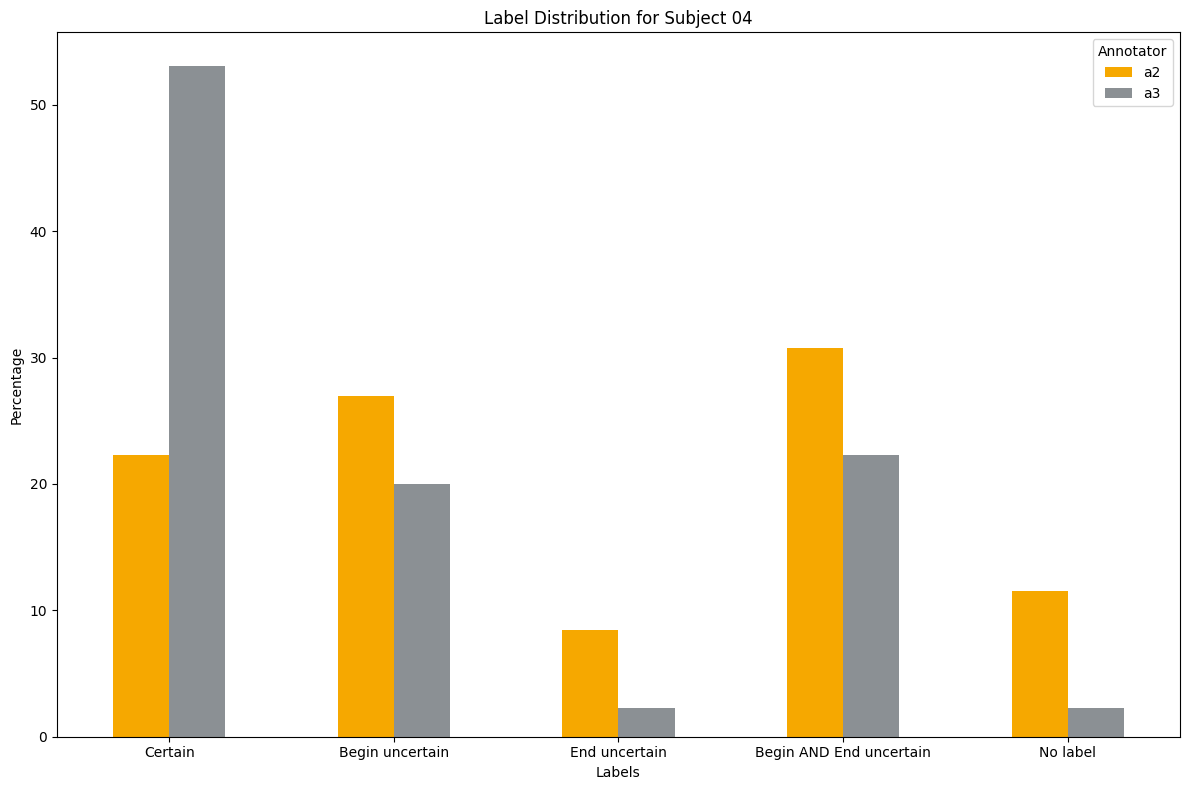

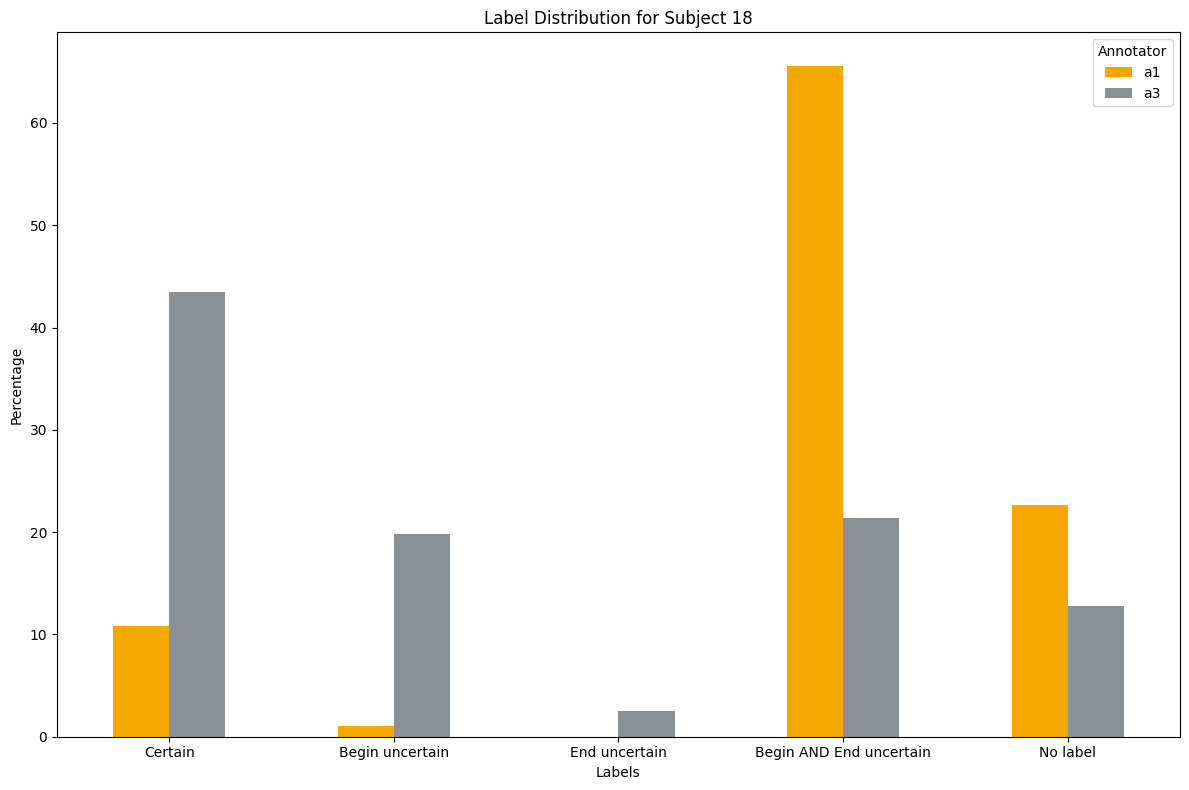

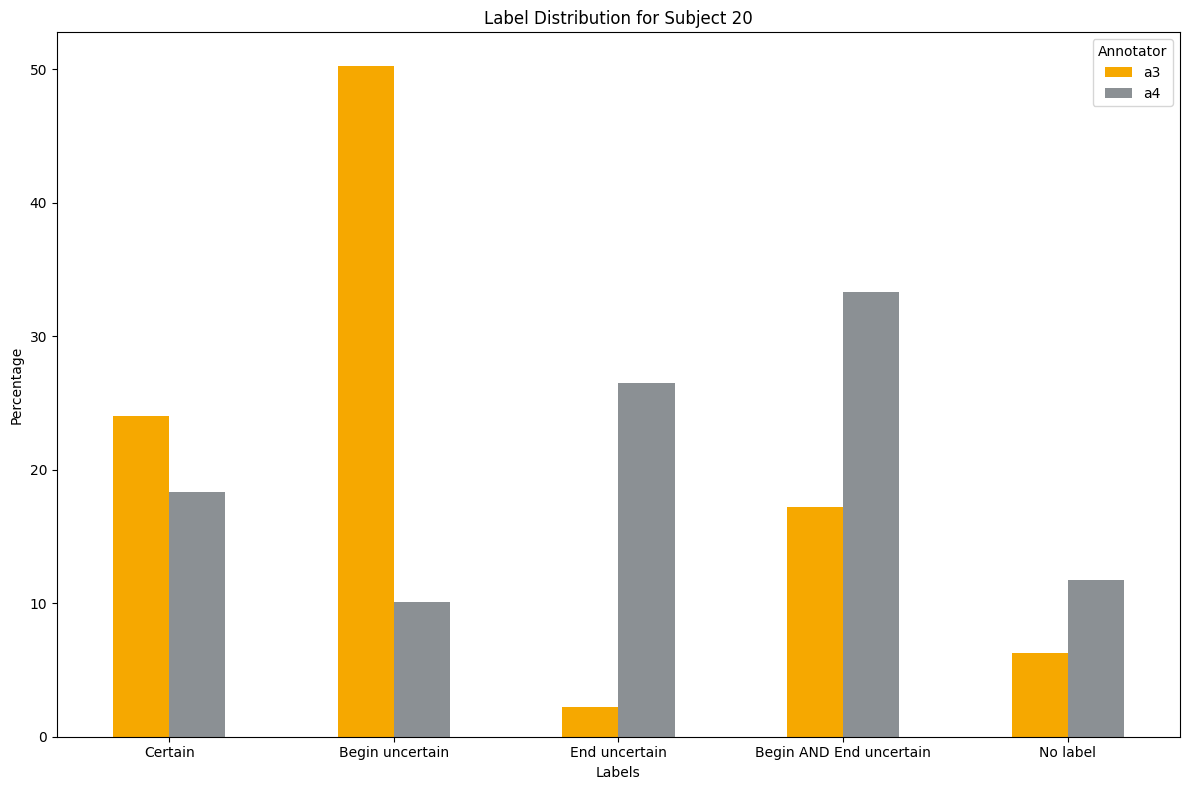

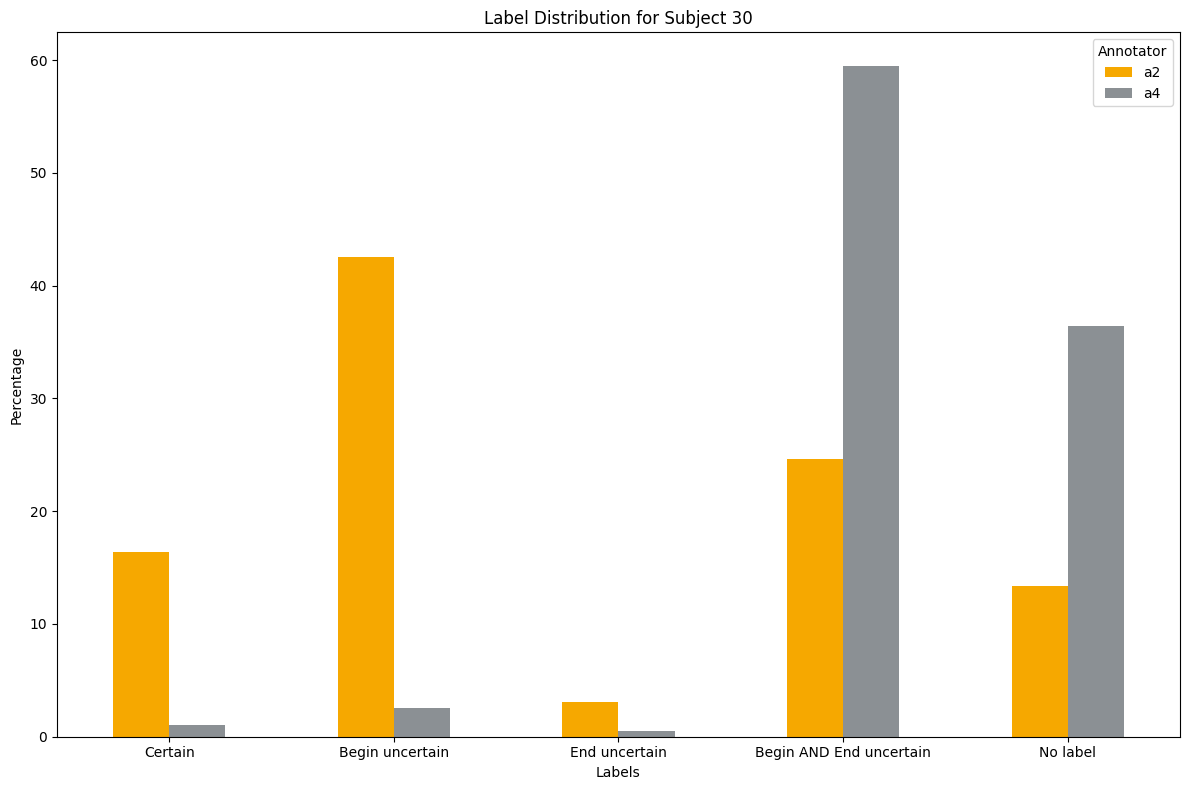

In [25]:
# Calculates distribution of label types by subject and annotator
#Plot distributions per subject
def count_label_distribution_by_subject_in_percent():
    file_name = "label_distribution_by_subject_percentage.csv"
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Subject", "Annotator"] + labels + ["Total number of labels"])
        
        for subject in subjects:
            for annotator in annotators:
                total_set_labels = get_total_user_labels(subject)
                path = os.path.join(relabeled_subjects_path, f"{annotator}_subject_{subject}.csv")

                if os.path.exists(path):
                    label_counts_list = list(labels_in_percent(count_labels_sum(path), total_set_labels).values())
                    writer.writerow([subject, annotator] + label_counts_list + [total_set_labels])
    return pd.read_csv(file_name, dtype={'Subject': str})

distribution_df = count_label_distribution_by_subject_in_percent()  
print(distribution_df)

def plot_label_distribution_by_subject_in_percent(df):
    df.drop(columns=["Total number of labels"], inplace=True)

    for subject in subjects:
        subject_df = df[df['Subject'] == subject].copy()
        subject_df.set_index("Annotator", inplace = True)
        subject_df.drop('Subject', axis=1, inplace=True)
        subject_df = subject_df.T

        fig, ax = plt.subplots(figsize=(12, 8))
        subject_df.plot(kind='bar', ax=ax, color = colors)
        plt.title(f'Label Distribution for Subject {subject}')
        plt.xlabel('Labels')
        plt.ylabel('Percentage')
        plt.xticks(rotation=0, ha='center')
        plt.legend(title='Annotator')
        plt.tight_layout()
        output_path =  f'Label Distribution for Subject {subject}.png'
        plt.savefig(output_path)
        plt.show()
        plt.close()
        
plot_label_distribution_by_subject_in_percent(distribution_df)

  Subject  Certain_mean  Certain_std  Begin_uncertain_mean  \
0      01         23.62         2.93                 13.95   
1      03         36.44         1.25                 17.78   
2      04         37.70        21.76                 23.46   
3      18         27.14        23.10                 10.43   
4      20         21.17         4.05                 30.19   
5      30          8.72        10.88                 22.56   

   Begin_uncertain_std  End_uncertain_mean  End_uncertain_std  \
0                 6.83                2.08               2.54   
1                21.37                1.78               1.89   
2                 4.89                5.39               4.35   
3                13.32                1.25               1.77   
4                28.40               14.34              17.19   
5                28.28                1.80               1.82   

   Begin_AND_End_uncertain_mean  Begin_AND_End_uncertain_std  No_label_mean  \
0                         19.7

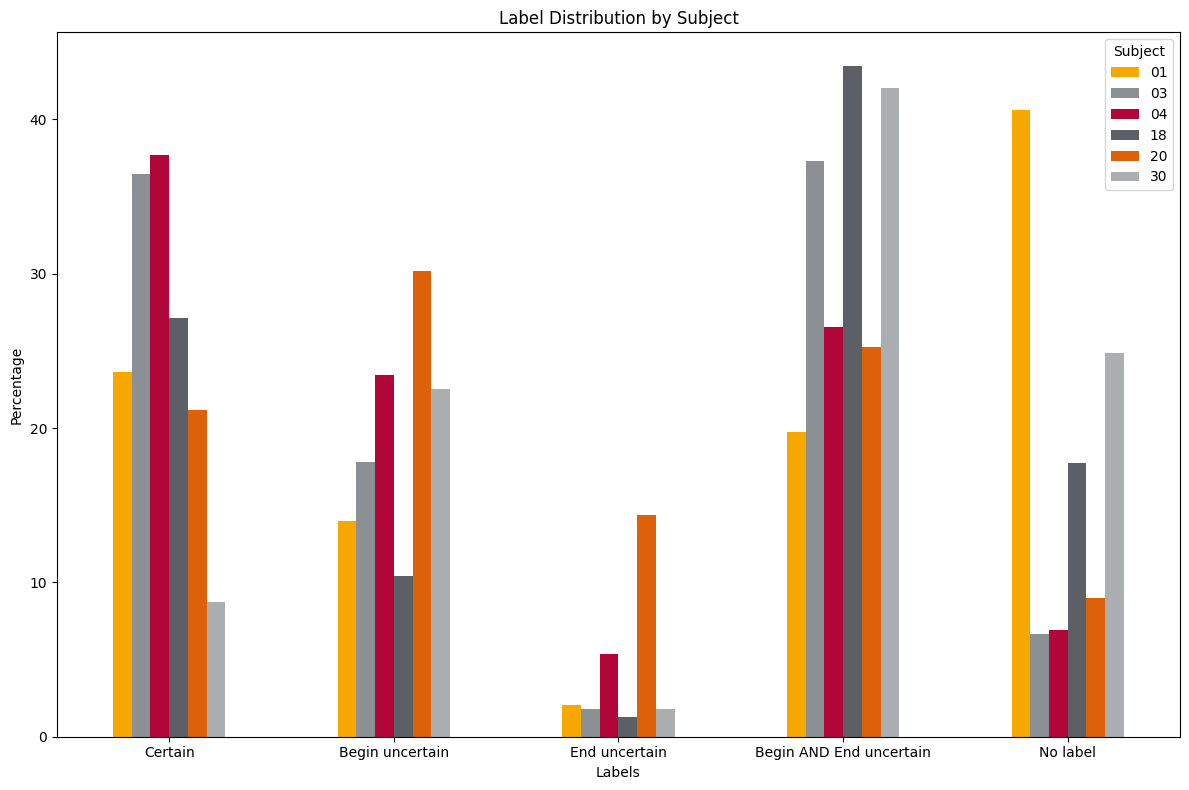

In [26]:

def label_distribution_by_subject(df):
    file_name = 'label_distribution_by_subject.csv'
    result_df = df.groupby('Subject').agg({
        'Certain': ['mean', 'std'],
        'Begin uncertain': ['mean', 'std'],
        'End uncertain': ['mean', 'std'],
        'Begin AND End uncertain': ['mean', 'std'],
        'No label': ['mean', 'std']
    }).reset_index()
    
    result_df.columns = ['Subject', 
                         'Certain_mean', 'Certain_std', 
                         'Begin_uncertain_mean', 'Begin_uncertain_std',
                         'End_uncertain_mean', 'End_uncertain_std',
                         'Begin_AND_End_uncertain_mean', 'Begin_AND_End_uncertain_std',
                         'No_label_mean', 'No_label_std']
    
    result_df = result_df.round(2)
    result_df.to_csv(file_name, index=False)
    return pd.read_csv(file_name, dtype={'Subject': str})

def plot_df(df):
    mean_df = df.groupby('Subject').agg({
        'Certain': 'mean',
        'Begin uncertain': 'mean',
        'End uncertain': 'mean',
        'Begin AND End uncertain': 'mean',
        'No label': 'mean'
    }).reset_index()
    mean_df.set_index("Subject", inplace=True)
    mean_df = mean_df.T
    fig, ax = plt.subplots(figsize=(12, 8))
    mean_df.plot(kind='bar', ax=ax, color = colors)
    plt.title('Label Distribution by Subject')
    plt.xlabel('Labels')
    plt.ylabel('Percentage')
    plt.xticks(rotation=0, ha='center')
    plt.legend(title='Subject')
    plt.tight_layout()
    output_path =  f'Mean Label Distribution by Subject.png'
    plt.savefig(output_path)
    plt.show()
    plt.close()
    
result_df = label_distribution_by_subject(distribution_df)
print(result_df)
plot_df(distribution_df)


----
{'annotation_id': '135', 'annotator': '1', 'created_at': '2024-01-23T12:44:46.763635Z', 'datetime': '/data/upload/2/43e420f5-OCDetect_01_recording_33_229da48b-f830-4ee9-8d9f-dbe48358d99f_10.csv', 'id': '170', 'label': '[{"start":"2021-12-31 16:17:23.120000","end":"2021-12-31 16:22:38.000000","instant":false,"timeserieslabels":["Begin uncertain"]}]', 'lead_time': '57.038', 'updated_at': '2024-01-23T12:44:46.763662Z'}
----
   Duration Subject Annotator
0      5.02      01        a1
1      6.88      01        a1
2     71.40      01        a1
3     30.66      01        a1
4     29.16      01        a1


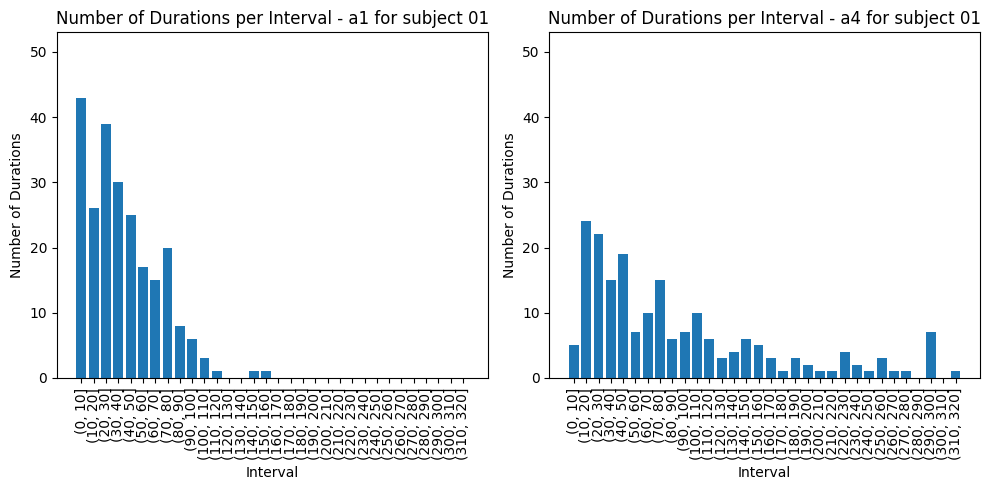

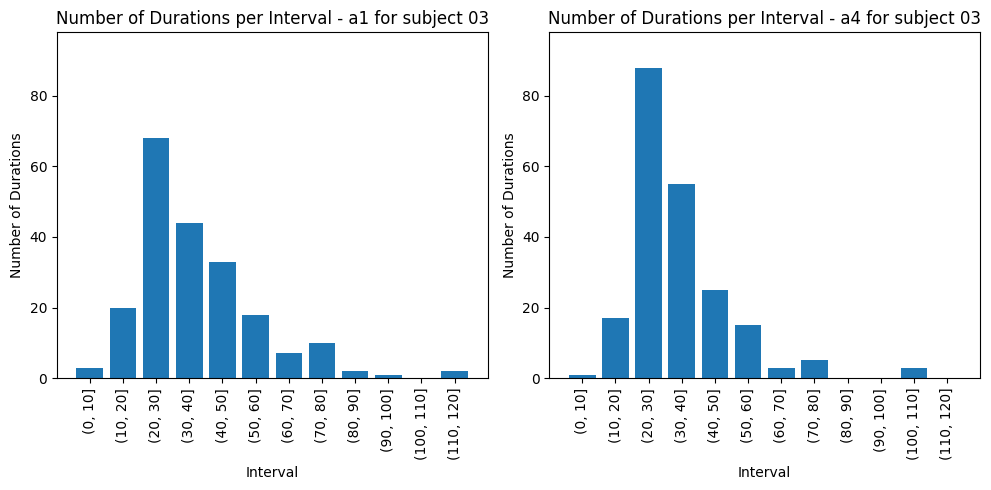

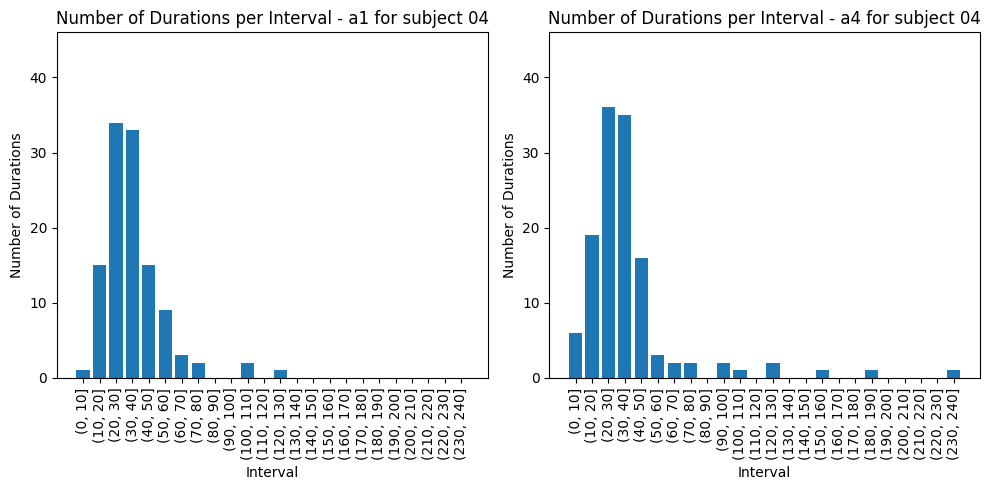

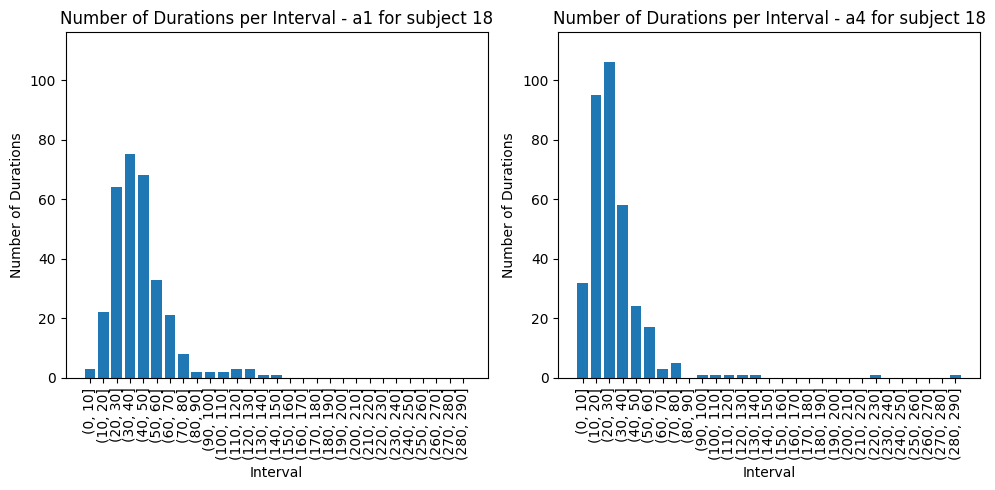

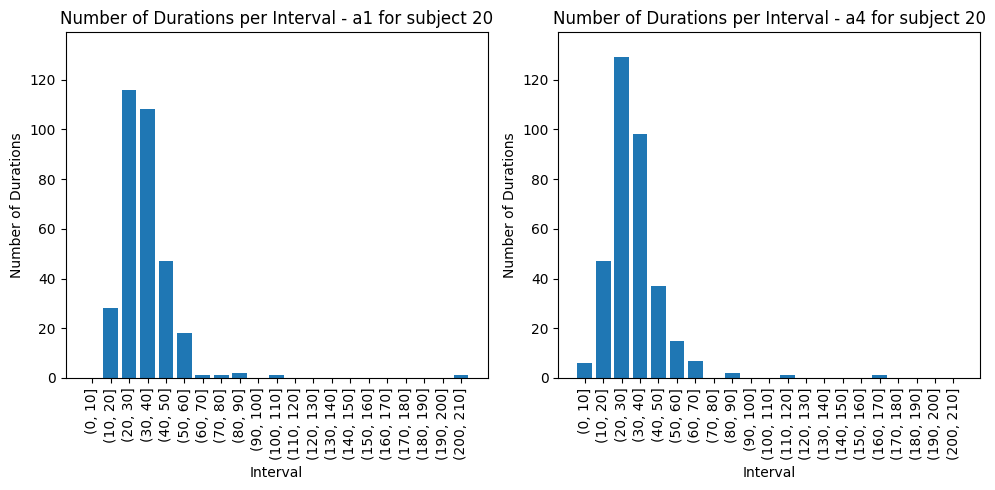

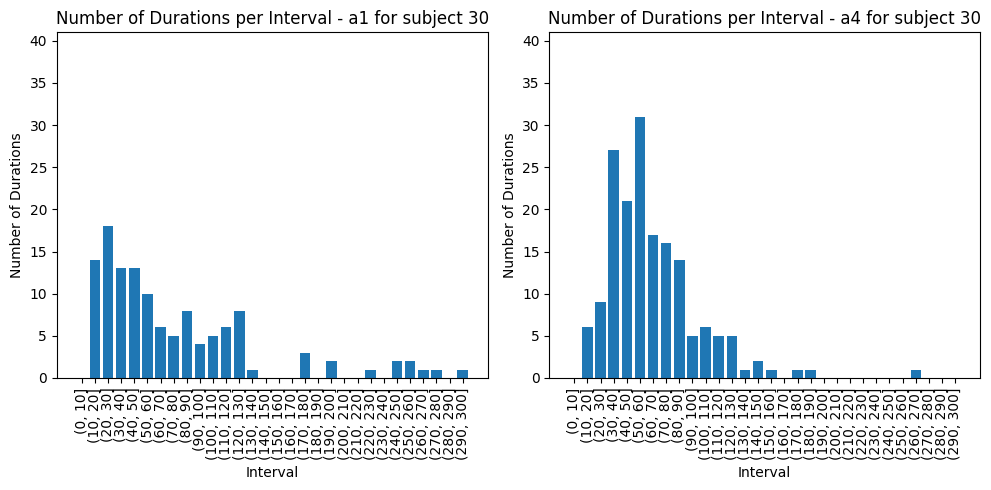

'\nimport csv\nimport json\nimport pandas as pd\n\ndef check(windows_path, output_csv_path, subject):\n    with open(output_csv_path, \'w\', newline=\'\') as output_file:\n        fieldnames = [\'file name\', \'start_1\', \'end_1\', \'duration_1\', \'start_2\', \'end_2\', \'duration_2\' ]\n        writer = csv.DictWriter(output_file, fieldnames=fieldnames)\n        writer.writeheader()\n\n        with open(windows_path, \'r\') as windows_file:\n            windows_reader = csv.DictReader(windows_file)\n            for window_row in windows_reader:\n                #print(window_row[\'file name\'])\n                #break\n                window_start = pd.to_datetime(window_row[\'start\'])\n                window_end = pd.to_datetime(window_row[\'end\'])\n                pairs = []\n                for annotator in annotators:\n                    path = os.path.join(relabeled_subjects_path, f"{annotator}_subject_{subject}.csv")\n                    if os.path.exists(path):\n          

In [27]:
# Calculate mean, max, min and standard deviation for handwashing activities duration by subject and annotator

def get_all_hw_durations(path):
    durations = []
    count = 0
    lessFiveDuration = 0
    moreTwoHundredDuration = 0
    with open(path, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            labels_json = row.get("label")

            if labels_json: 
                labels = json.loads(labels_json)
                for label in labels:
                    start_time = pd.to_datetime(label['start'])
                    end_time = pd.to_datetime(label['end'])
                    duration = (end_time - start_time).total_seconds()
                    
                    count+=1
                    if duration > 200: # just interesting to check
                        moreTwoHundredDuration +=1
                    if duration < 5:
                        lessFiveDuration +=1
                    durations.append(duration)    
 
    return durations
    
def count_hw_durations():
    file_name = "length_of_hw_in_seconds.csv"
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Subject", "Annotator", "Mean duration", "Std", "Min", "Max"])
        
        for subject in subjects:
            for annotator in annotators:
                path = os.path.join(relabeled_subjects_path, f"{annotator}_subject_{subject}.csv")
                if os.path.exists(path):
                    durations = get_all_hw_durations(path)
                    
                    if durations:
                        mean_duration = round(np.mean(durations),2)
                        std_deviation = round(np.std(durations), 2)
                        min_duration = round(np.min(durations), 2)
                        max_duration = round(np.max(durations), 2)
                        writer.writerow([subject, annotator, mean_duration, std_deviation, min_duration, max_duration])
    return pd.read_csv(file_name, dtype={'Subject': str})

def get_hw_durations_dfs():
    file_name = "length_of_hw_in_seconds.csv"
    result_dfs = [] 

    for subject in subjects:
        for annotator in annotators:
            path = os.path.join(relabeled_subjects_path, f"{annotator}_subject_{subject}.csv")
            if os.path.exists(path):
                durations = get_all_hw_durations(path)
                if durations:
                    durations_df = pd.DataFrame(durations, columns=["Duration"])
                    durations_df['Subject'] = subject
                    durations_df['Annotator'] = annotator
                    result_dfs.append(durations_df)

    result_df = pd.concat(result_dfs, ignore_index=True)
                    
    print(result_df.head())                
    return result_df
    

def plot_durations(result_df):
    subjects = result_df['Subject'].unique()
    annotators = result_df['Annotator'].unique()
    interval_size = 10
    max_duration = 0
    for subject in subjects:
        subject_dfs = []
        for annotator in annotators:
            path = os.path.join(relabeled_subjects_path, f"{annotator}_subject_{subject}.csv")
            if os.path.exists(path):
                df = result_df[(result_df['Subject'] == subject) & (result_df['Annotator'] == annotator)].copy()    
                subject_dfs.append(df)
        max_durations = []
        for df in subject_dfs:
            max_duration = df['Duration'].max()
            max_durations.append(max_duration)


        overall_max_duration = max(max_durations)
        max_duration = math.ceil(overall_max_duration / 10) * 10
        bins = np.arange(0, max_duration + interval_size, interval_size)
        
        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        max_counts = 0
        for idx, df in enumerate(subject_dfs):
            df['Interval'] = pd.cut(df['Duration'], bins=bins)
            interval_counts = df['Interval'].value_counts().sort_index()
            max_counts = max(max_counts, interval_counts.max())
            axs[idx].bar(interval_counts.index.astype(str), interval_counts.values)
            axs[idx].set_xlabel('Interval')
            axs[idx].set_ylabel('Number of Durations')
            axs[idx].set_title(f'Number of Durations per Interval - {annotators[idx]} for subject {subject}')
            axs[idx].tick_params(axis='x', rotation=90)
        for ax in axs:
            ax.set_ylim(0, max_counts + 10) 
        plt.tight_layout()
        plt.show()


durations_df = get_hw_durations_dfs()
plot_durations(durations_df)



In [7]:
def check(windows_path, output_csv_path, subject):
    with open(output_csv_path, 'w', newline='') as output_file:
        fieldnames = ['file name', 'start_1', 'end_1', 'duration_1', 'start_2', 'end_2', 'duration_2' ]
        writer = csv.DictWriter(output_file, fieldnames=fieldnames)
        writer.writeheader()

        with open(windows_path, 'r') as windows_file:
            windows_reader = csv.DictReader(windows_file)
            for window_row in windows_reader:
                #print(window_row['file name'])
                #break
                window_start = pd.to_datetime(window_row['start'])
                window_end = pd.to_datetime(window_row['end'])
                pairs = []
                for annotator in annotators:
                    path = os.path.join(relabeled_subjects_path, f"{annotator}_subject_{subject}.csv")
                    if os.path.exists(path):
                        pairs.append({'Subject': subject, 'Annotator': annotator})
                annotator1 = f"{pairs[0]['Annotator']}_subject_{pairs[0]['Subject']}.csv"
                annotator2 =  f"{pairs[1]['Annotator']}_subject_{pairs[1]['Subject']}.csv"
                path1 = os.path.join(relabeled_subjects_path, annotator1)
                dfA1 = pd.read_csv(path1)
                path2 = os.path.join(relabeled_subjects_path, annotator2)
                dfA2 = pd.read_csv(path2)
        
                matching_rows_file1 = []
                matching_rows_file2 = []
                if True: # to lazy to ident
                    for index, file1_row in dfA1.iterrows():
                        #print(file1_row)
                        #print("----")
                        string = file1_row['datetime']
                        if window_row['file name'] in string:
                            matching_rows_file1.append(file1_row)
                            
                            
                            
                    start_1 = 0
                    end_1 = 0
                    start_2 = 0
                    end_2 = 0
                    duration_1 = 0
                    duration_2 = 0
                    for index, file2_row in dfA2.iterrows():
                        if window_row['file name'] in file2_row['datetime']:
                            matching_rows_file2.append(file2_row)
                    
                    for row in matching_rows_file1:
                        #print(row)
                        labels_json_1 = row["label"]
                        if not pd.isna(labels_json_1):
                            labels_1 = json.loads(labels_json_1)
                            for label_1 in labels_1:
                                start_1 = pd.to_datetime(label_1['start'])
                                end_1 = pd.to_datetime(label_1['end'])
                                if(start_1 >= window_start and end_1 <= window_end):
                                    duration_1 = (end_1 - start_1).total_seconds()
                               
                    if duration_1 == 0:
                        start_1 = 0
                        end_1 = 0
                    for row in matching_rows_file2:
                        #print(row)
                        labels_json_2 = row["label"]
                        if not pd.isna(labels_json_2):
                            labels_2 = json.loads(labels_json_2)
                            for label_2 in labels_2:
                                start_2 = pd.to_datetime(label_2['start'])
                                end_2 = pd.to_datetime(label_2['end'])
                                if(start_2 >= window_start and end_2 <= (window_end + timedelta(seconds=20))):#excluded the windows where time is over the window end
                                    duration_2 = (end_2 - start_2).total_seconds()
                    if duration_2 == 0:
                        start_2 = 0
                        end_2 = 0
                    #if (duration_1 > 200 or duration_1 < 5) or (duration_2 > 200 or duration_2 < 5):
                    if (((duration_1 < 5) and (duration_1 != 0)) or (duration_2 != 0 and duration_2 < 5)):
                    #if (duration_1 > 200 or duration_2 > 200):   
                      
                        
                        writer.writerow({
                            'file name': window_row['file name'],
                            'start_1': start_1,
                            'end_1': end_1,
                            'duration_1': duration_1,
                            'start_2': start_2,
                            'end_2': end_2,
                            'duration_2': duration_2
                        })
                    
    df = pd.read_csv(output_csv_path)
    
    # Sort the DataFrame by the 'file name' column
    df_sorted = df.sort_values(by='file name')
    
    # Overwrite the CSV file with the sorted DataFrame
    df_sorted.to_csv(output_csv_path, index=False)        
                    
                  

                                        
for subject in subjects:
    path = f'/dhc/groups/ocdetect/label_windows_clean/subject_{subject}.csv'
    if os.path.exists(path):
        check(path, f'checking_{subject}.csv', subject)

In [11]:
#Number of automated set labels per subject and mean duration with std
result_df = pd.DataFrame(columns = ['subject', 'mean duration', 'std'])
for subject in subjects:
    subject_path = os.path.join(automated_labels_path, f"subject_{subject}.csv")
    df = pd.read_csv(subject_path)
    df['end'] = pd.to_datetime(df['end'], format='%Y-%m-%d %H:%M:%S.%f')
    df['start'] = pd.to_datetime(df['start'], format='%Y-%m-%d %H:%M:%S.%f')
    df['duration'] = (df['end'] - df['start']).dt.total_seconds()
    mean = df['duration'].mean()
    std = df['duration'].std()
    number_of_labels = len(df)
    new_row = {'subject': subject, 'mean duration': mean, 'std': std}
    result_df.loc[len(result_df)] = new_row
print(result_df)

  subject  mean duration       std
0      01      38.644498  6.336224
1      03      37.966316  0.343509
2      04      37.674531  3.086376
3      18      38.092565  1.809175
4      20      37.911734  1.641841
5      30      37.462118  4.564282


In [29]:
# calculate the distance of annotator set labels to the user-set label
#starts inside the start-end times of the user-set label and 5 or less minutes
# negative values mean that annotator label was set after user label
results = []
for subject in subjects:
    path = os.path.join(labels_windows, f"subject_{subject}.csv")
    window_df = pd.read_csv(path)
    window_df['start'] = pd.to_datetime(window_df['start'])
    window_df['end'] = pd.to_datetime(window_df['end'])
    for annotator in annotators:
        annotation_path = os.path.join(extracted_labels, f"{annotator}_subject_{subject}.csv")
        if os.path.exists(annotation_path):
            differences = []
            annotator_labels = pd.read_csv(annotation_path)
            annotator_labels['start'] = pd.to_datetime(annotator_labels['start'])
            annotator_labels['end'] = pd.to_datetime(annotator_labels['end'])
            for window_idx, window_row in window_df.iterrows():
                window_start = window_row['start']
                window_end = window_row['end']
                    
                    # Find labels that start between the start and end times of the window
                matching_labels = annotator_labels[
                        (annotator_labels['start'] >= window_start) & 
                        (annotator_labels['start'] <= window_end) 
                    ]

                if len(matching_labels) == 1:
                    label_end = matching_labels.iloc[0]['end']
                    time_difference = (window_end - label_end).total_seconds()
                    differences.append(time_difference)
                elif len(matching_labels) > 1:
                    print("number of found labels: ", len(matching_labels))
            if differences:
                mean_diff = np.mean(differences)
                min_diff = np.min(differences)
                max_diff = np.max(differences)
                std_diff = np.std(differences)
                    
            results.append({
                        'subject': subject,
                        'annotator': annotator,
                        'mean_diff': mean_diff,
                        'min_diff': min_diff,
                        'max_diff': max_diff,
                        'std_diff': std_diff
            })

results_df = pd.DataFrame(results)
print(result_df)
results_df.to_csv('differences_to_user_set_label.csv', index=False)

  Subject  Certain_mean  Certain_std  Begin_uncertain_mean  \
0      01         23.62         2.93                 13.95   
1      03         36.44         1.25                 17.78   
2      04         37.70        21.76                 23.46   
3      18         27.14        23.10                 10.43   
4      20         21.17         4.05                 30.19   
5      30          8.72        10.88                 22.56   

   Begin_uncertain_std  End_uncertain_mean  End_uncertain_std  \
0                 6.83                2.08               2.54   
1                21.37                1.78               1.89   
2                 4.89                5.39               4.35   
3                13.32                1.25               1.77   
4                28.40               14.34              17.19   
5                28.28                1.80               1.82   

   Begin_AND_End_uncertain_mean  Begin_AND_End_uncertain_std  No_label_mean  \
0                         19.7